<a href="https://colab.research.google.com/github/LucasCta/Doodle_Identification/blob/main/Doodles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install quickdraw

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from pathlib import Path
from quickdraw import QuickDrawDataGroup, QuickDrawData

import requests

from tensorflow import keras
from keras import layers
from keras.layers import BatchNormalization

import os
import datetime
from keras.callbacks import TensorBoard

In [ ]:
image_size = (28, 28)
def generate_class_images(name, max_drawings, recognized):
    directory = Path("dataset/" + name)
    if not directory.exists():
        directory.mkdir(parents=True)
    images = QuickDrawDataGroup(name, max_drawings=max_drawings, recognized=recognized)
    for img in images.drawings:
        filename = directory.as_posix() + "/" + str(img.key_id) + ".png"
        img.get_image(stroke_width=3).resize(image_size).save(filename)

In [ ]:
url = 'https://gist.githubusercontent.com/atduskgreg/3cf8ef48cb0d29cf151bedad81553a54/raw/82f142562cf50b0f6fb8010f890b2f934093553e/animals.txt'
page = requests.get(url)
animals = page.text.split("\n")
animals = list(map(lambda x: x.lower(), animals))
animals = list(filter(lambda x: x in animals, QuickDrawData().drawing_names))
print(animals)

In [ ]:
!rm -rf dataset/

In [ ]:
for i, label in enumerate(QuickDrawData().drawing_names):
    if label in animals:
      generate_class_images(label, max_drawings=10000, recognized=True)

In [ ]:
!ls dataset | wc -l && ls dataset/

In [ ]:
batch_size = 32
dataset_dir = Path("dataset/")
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)
test_ds = val_ds.take(150)
val_ds = val_ds.skip(150)

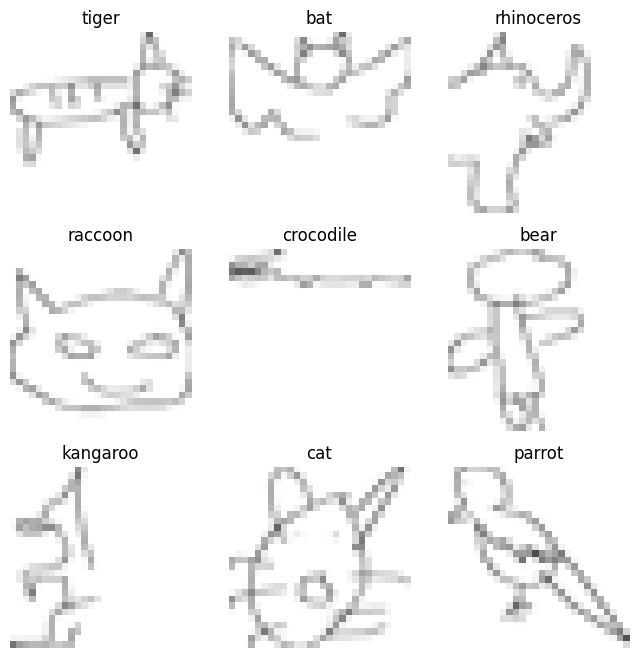

In [ ]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        data = images[i].numpy().astype("uint8")
        plt.imshow(data, cmap='gray', vmin=0, vmax=255)
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [ ]:
n_classes = len(animals)
input_shape = (28, 28, 1)

model = keras.Sequential([
    layers.Rescaling(1. / 255, input_shape=input_shape),
    layers.BatchNormalization(),

    layers.Conv2D(6, kernel_size=(3, 3), padding="same", activation="relu"),
    layers.Conv2D(8, kernel_size=(3, 3), padding="same", activation="relu"),
    layers.Conv2D(10, kernel_size=(3, 3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),

    layers.Dense(700, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(500, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(400, activation="relu"),
    layers.Dropout(0.2),

    layers.Dense(n_classes, activation="softmax")
])

In [ ]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=32,
    verbose=1,
    callbacks=[tensorboard_callback]
)

In [ ]:
model.evaluate(test_ds)

In [ ]:
model.predict(test_ds)

In [ ]:
model.save("/content/model")

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("/content/model/")
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)